## Mushroom Image Classification using Transfer Learning (ResNet50V2, ResNet50, VGG16, VGG19)

In [ ]:
# Importing the necessary libraries
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from glob import glob
from google.colab import drive
import zipfile
import os
from keras.applications import ResNet50V2, ResNet50, VGG16, vgg19
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_classes = 4
num_epochs = 20
img_width = 224
img_height = 224
early_stop_patience = 3
batch_size_training = 64
batch_size_validation = 64

In [ ]:
data_generator = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = data_generator.flow_from_directory(
    '/content/drive/My Drive/archive',
    target_size = (img_height, img_width),
    batch_size = batch_size_training,
    class_mode = 'categorical')

validation_generator = data_generator.flow_from_directory(
    '/content/drive/My Drive/archive',
    target_size = (img_height, img_width),
    batch_size = batch_size_validation,
    class_mode = 'categorical',
    subset = 'validation')

Found 3409 images belonging to 4 classes.
Found 681 images belonging to 4 classes.


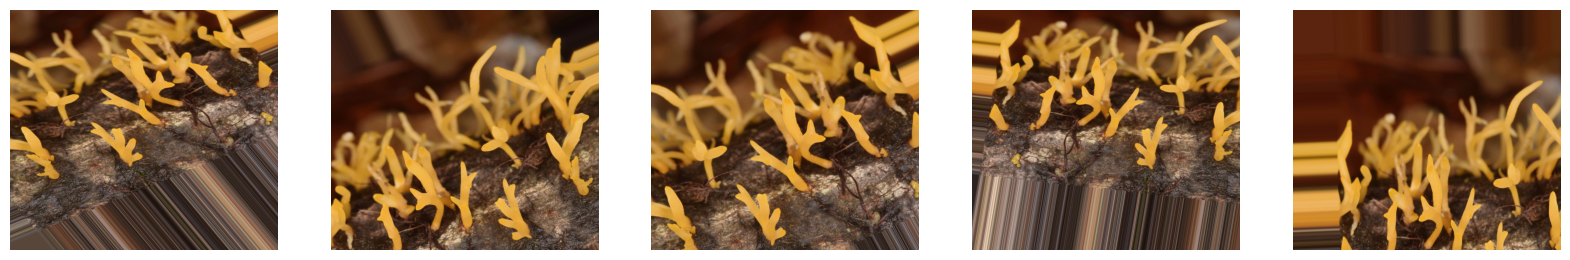

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define augmentation parameters
data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Load a sample image
image_path = '/content/drive/My Drive/archive/edible sporocarp/ncvc (2).jpeg'
image = load_img(image_path)
image_array = img_to_array(image)
image_array = image_array.reshape((1,) + image_array.shape)

# Plot the augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Generate augmented images
i = 0
for batch in data_generator.flow(image_array, batch_size=1):
    axes[i].imshow(batch[0].astype('uint8'))
    axes[i].axis('off')
    i += 1
    if i == 5: # We will display 5 images
        break

plt.show()

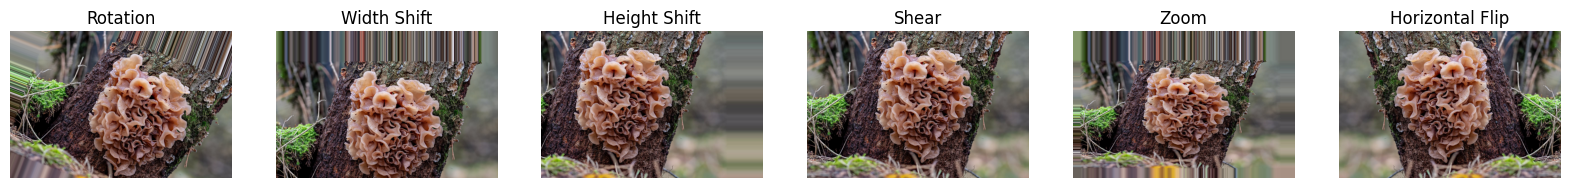

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Load a sample image
image_path = '/content/drive/My Drive/archive/edible sporocarp/ncvc (3).jpeg' # Change this to the path of your image
image = load_img(image_path)
image_array = img_to_array(image)
image_array = image_array.reshape((1,) + image_array.shape)

# Define augmentation parameters for each technique
augmentations = {
    "Rotation": ImageDataGenerator(rotation_range=40),
    "Width Shift": ImageDataGenerator(width_shift_range=0.4),
    "Height Shift": ImageDataGenerator(height_shift_range=0.4),
    "Shear": ImageDataGenerator(shear_range=0.4),
    "Zoom": ImageDataGenerator(zoom_range=0.4),
    "Horizontal Flip": ImageDataGenerator(horizontal_flip=True),
}

# Plot the augmented images
fig, axes = plt.subplots(1, len(augmentations), figsize=(20, 5))

for i, (label, data_gen) in enumerate(augmentations.items()):
    batch = data_gen.flow(image_array, batch_size=1).next()
    axes[i].imshow(batch[0].astype('uint8'))
    axes[i].axis('off')
    axes[i].set_title(label)

plt.savefig('/content/drive/My Drive/archive/augmented_images.png') # Save the plot to the archive directory
plt.show()

In [ ]:
def plot_learning_curves(hist):
    epochs = np.arange(0, len(hist.history['loss'])) + 1
    sns.set(style='ticks')
    fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex=True)
    ax[0].plot(epochs, hist.history['loss'], label = 'Training loss', marker = 'o', ls = '--')
    ax[0].plot(epochs, hist.history['val_loss'], label = 'Validation loss', marker = 'o', ls = '--')

    ax[1].plot(epochs, hist.history['accuracy'], label = 'Training accuracy', marker = 'o', ls = '--')
    ax[1].plot(epochs, hist.history['val_accuracy'], label = 'Validation accuracy', marker = 'o', ls = '--')

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss vs. Epoch')
    ax[0].legend()

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy vs. Epoch')
    ax[1].legend()
    sns.despine(trim=True, offset=5)

### ResNet50v2 Model (1)

In [ ]:
model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height, 3), pooling = 'avg')

for layer in model.layers:
    layer.trainable = False

# Creating trainable layers
x = model.output
x = BatchNormalization()(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes, activation = 'softmax')(x)

# Compute finetuned model
resnet50_model = Model(inputs = model.input, outputs = predictions)

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
import tensorflow as tf

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
resnet50_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = METRICS)

In [ ]:
# Early stopping and checkpointing the best model in ../working dir and
# restoring that as the model for prediction

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = early_stop_patience)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/resnet50_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
history = resnet50_model.fit(train_generator, epochs = 20, validation_data = validation_generator, callbacks = [cb_checkpointer, cb_early_stopper])

Epoch 1/20
54/54 [==============================] - 29s 459ms/step - loss: 0.8850 - accuracy: 0.8396 - precision: 0.7048 - recall: 0.6169 - auc: 0.8787 - val_loss: 0.5040 - val_accuracy: 0.9189 - val_precision: 0.8912 - val_recall: 0.7695 - val_auc: 0.9650
Epoch 2/20
54/54 [==============================] - 23s 428ms/step - loss: 0.2633 - accuracy: 0.9565 - precision: 0.9319 - recall: 0.8912 - auc: 0.9900 - val_loss: 0.2377 - val_accuracy: 0.9666 - val_precision: 0.9483 - val_recall: 0.9163 - val_auc: 0.9952
Epoch 3/20
54/54 [==============================] - 35s 654ms/step - loss: 0.1068 - accuracy: 0.9867 - precision: 0.9767 - recall: 0.9701 - auc: 0.9988 - val_loss: 0.0777 - val_accuracy: 0.9989 - val_precision: 1.0000 - val_recall: 0.9956 - val_auc: 1.0000
Epoch 4/20
54/54 [==============================] - 33s 616ms/step - loss: 0.0649 - accuracy: 0.9944 - precision: 0.9909 - recall: 0.9868 - auc: 0.9993 - val_loss: 0.0355 - val_accuracy: 0.9989 - val_precision: 0.9985 - val_recal

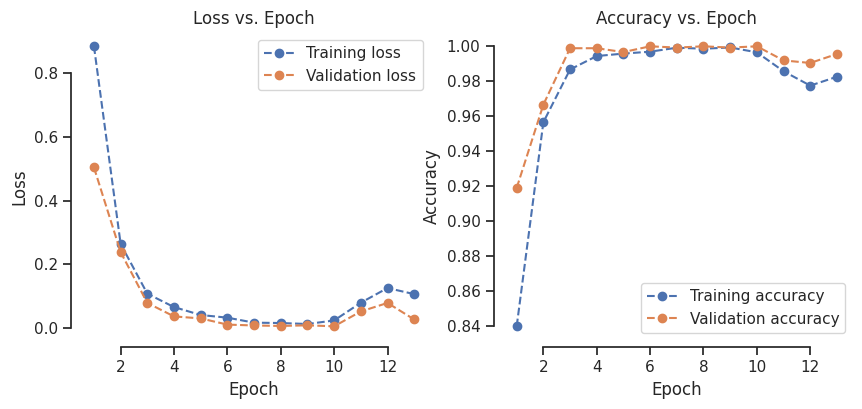

In [ ]:
import seaborn as sns
plot_learning_curves(history)

In [ ]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Print the DataFrame
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.885045,0.839616,0.704759,0.616896,0.878734,0.504009,0.918869,0.891156,0.769457,0.964997
1,0.263323,0.956512,0.931902,0.891170,0.989972,0.237723,0.966593,0.948328,0.916300,0.995193
2,0.106845,0.986726,0.976669,0.970079,0.998785,0.077739,0.998899,1.000000,0.995595,0.999996
3,0.064861,0.994426,0.990869,0.986800,0.999293,0.035499,0.998899,0.998529,0.997063,0.999997
4,0.039891,0.995820,0.991784,0.991493,0.999822,0.029203,0.996696,0.994118,0.992658,0.999983
5,0.031544,0.996920,0.994130,0.993546,0.999895,0.009738,1.000000,1.000000,1.000000,1.000000
6,0.015833,0.999193,0.998533,0.998240,0.999998,0.006965,0.999266,0.998532,0.998532,0.999999
7,0.014695,0.998607,0.997359,0.997067,0.999987,0.005548,1.000000,1.000000,1.000000,1.000000
8,0.011617,0.999340,0.998826,0.998533,0.999997,0.007451,0.999266,0.998532,0.998532,0.999999
9,0.022778,0.996553,0.993251,0.992960,0.999945,0.004378,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
# Get the true labels
y_true = validation_generator.classes

# Predict the probability distribution of the data
predictions = resnet50_model.predict(validation_generator, verbose=1)

# Get the predicted class
y_pred = np.argmax(predictions, axis=1)

11/11 [==============================] - 5s 410ms/step


In [ ]:
resnet50_model.evaluate(validation_generator)

11/11 [==============================] - 5s 420ms/step - loss: 0.0259 - accuracy: 0.9956 - precision: 0.9912 - recall: 0.9912 - auc: 0.9999


[0.025860222056508064,
 0.9955947399139404,
 0.9911894202232361,
 0.9911894202232361,
 0.9998674988746643]

### ResNet50v2 Model (2)

In [ ]:
num_classes = 4
channel = 3
img_width = 224
img_height = 224
early_stop_patience = 3

In [ ]:
data_generator = ImageDataGenerator(
    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    '/content/drive/My Drive/archive',
    target_size = (img_height, img_width),
    batch_size = batch_size_training,
    class_mode = 'categorical')

validation_generator = data_generator.flow_from_directory(
    '/content/drive/My Drive/archive',
    target_size = (img_height, img_width),
    batch_size = batch_size_validation,
    class_mode = 'categorical',
    subset = 'validation')

Found 3409 images belonging to 4 classes.
Found 681 images belonging to 4 classes.


In [ ]:
model = ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3), pooling = 'avg')

for layer in model.layers:
    layer.trainable = False

# Creating trainable layers
x = model.output
x = BatchNormalization()(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation = 'softmax')(x)

# Compute finetuned model
resnet50v2_model = Model(inputs = model.input, outputs = predictions)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
import tensorflow as tf

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
resnet50v2_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = METRICS)

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = early_stop_patience)
cb_checkpointer = ModelCheckpoint(filepath = './resnet50v2_best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
history = resnet50v2_model.fit(train_generator, epochs = 20, validation_data = validation_generator, callbacks = [cb_checkpointer, cb_early_stopper])

Epoch 1/20
54/54 [==============================] - 28s 428ms/step - loss: 1.8396 - accuracy: 0.6993 - precision: 0.3532 - recall: 0.2438 - auc: 0.5926 - val_loss: 3.1402 - val_accuracy: 0.6344 - val_precision: 0.2472 - val_recall: 0.2261 - val_auc: 0.4928
Epoch 2/20
54/54 [==============================] - 22s 404ms/step - loss: 1.3892 - accuracy: 0.7480 - precision: 0.4940 - recall: 0.3277 - auc: 0.7050 - val_loss: 1.3009 - val_accuracy: 0.7621 - val_precision: 0.5422 - val_recall: 0.3113 - val_auc: 0.7142
Epoch 3/20
54/54 [==============================] - 21s 396ms/step - loss: 1.1908 - accuracy: 0.7816 - precision: 0.5869 - recall: 0.4268 - auc: 0.7763 - val_loss: 0.9356 - val_accuracy: 0.8157 - val_precision: 0.7374 - val_recall: 0.4082 - val_auc: 0.8504
Epoch 4/20
54/54 [==============================] - 22s 415ms/step - loss: 1.0357 - accuracy: 0.8121 - precision: 0.6612 - recall: 0.5095 - auc: 0.8283 - val_loss: 0.8267 - val_accuracy: 0.8381 - val_precision: 0.7871 - val_recal

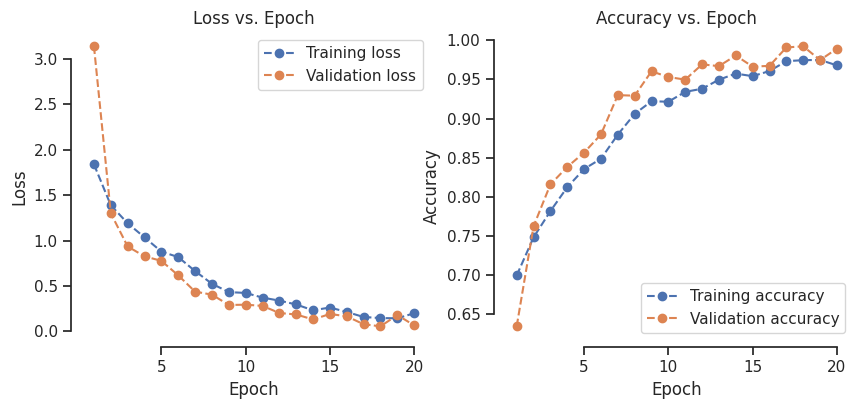

In [ ]:
plot_learning_curves(history)

In [ ]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Print the DataFrame
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,1.839632,0.699325,0.353166,0.243767,0.592585,3.140150,0.634361,0.247191,0.226138,0.492752
1,1.389164,0.748020,0.494029,0.327662,0.705005,1.300851,0.762115,0.542199,0.311307,0.714172
2,1.190784,0.781608,0.586930,0.426811,0.776264,0.935612,0.815712,0.737401,0.408223,0.850408
3,1.035659,0.812115,0.661210,0.509534,0.828273,0.826741,0.838106,0.787081,0.483113,0.888881
4,0.879096,0.835436,0.713136,0.571722,0.871495,0.777180,0.856461,0.776718,0.597651,0.897947
5,0.818589,0.848563,0.734637,0.617190,0.888435,0.617247,0.879589,0.810193,0.676946,0.936973
6,0.664280,0.879437,0.796838,0.694925,0.925154,0.438087,0.929883,0.906977,0.801762,0.973806
7,0.524784,0.905911,0.847386,0.760634,0.952509,0.404865,0.929148,0.892283,0.814978,0.974328
8,0.432911,0.922045,0.872145,0.806395,0.967550,0.291116,0.960352,0.952607,0.885463,0.990356
9,0.423812,0.921458,0.865541,0.811968,0.968388,0.294312,0.953010,0.927357,0.881057,0.986188


In [ ]:
# Get the true labels
y_true = validation_generator.classes

# Predict the probability distribution of the data
predictions = resnet50v2_model.predict(validation_generator, verbose=1)

# Get the predicted class
y_pred = np.argmax(predictions, axis=1)

11/11 [==============================] - 6s 444ms/step


In [ ]:
resnet50v2_model.evaluate(validation_generator)

11/11 [==============================] - 5s 392ms/step - loss: 0.0662 - accuracy: 0.9894 - precision: 0.9808 - recall: 0.9765 - auc: 0.9993


[0.06619030237197876,
 0.9893538951873779,
 0.9808259606361389,
 0.9765051603317261,
 0.999310314655304]

### VGG19 Model (3)

In [ ]:
from keras.applications.vgg19 import VGG19
model = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3), pooling = 'avg')

for layer in model.layers:
    layer.trainable = False

# Creating trainable layers
x = model.output
x = BatchNormalization()(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation = 'softmax')(x)

# Compute finetuned model
vgg19_model = Model(inputs = model.input, outputs = predictions)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
vgg19_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = METRICS)

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = early_stop_patience)
cb_checkpointer = ModelCheckpoint(filepath = './vgg19_best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
history = vgg19_model.fit(train_generator, epochs = 20, validation_data = validation_generator, callbacks = [cb_checkpointer, cb_early_stopper])

Epoch 1/20
54/54 [==============================] - 28s 449ms/step - loss: 1.3126 - accuracy: 0.8160 - precision: 0.6478 - recall: 0.5787 - auc: 0.8476 - val_loss: 0.6258 - val_accuracy: 0.8722 - val_precision: 0.7979 - val_recall: 0.6549 - val_auc: 0.9323
Epoch 2/20
54/54 [==============================] - 22s 399ms/step - loss: 0.6621 - accuracy: 0.8739 - precision: 0.7704 - recall: 0.7058 - auc: 0.9272 - val_loss: 0.3419 - val_accuracy: 0.9347 - val_precision: 0.8961 - val_recall: 0.8355 - val_auc: 0.9835
Epoch 3/20
54/54 [==============================] - 22s 402ms/step - loss: 0.4624 - accuracy: 0.9142 - precision: 0.8467 - recall: 0.8020 - auc: 0.9622 - val_loss: 0.2213 - val_accuracy: 0.9626 - val_precision: 0.9406 - val_recall: 0.9075 - val_auc: 0.9938
Epoch 4/20
54/54 [==============================] - 21s 396ms/step - loss: 0.3188 - accuracy: 0.9399 - precision: 0.8933 - recall: 0.8624 - auc: 0.9814 - val_loss: 0.1217 - val_accuracy: 0.9864 - val_precision: 0.9763 - val_recal

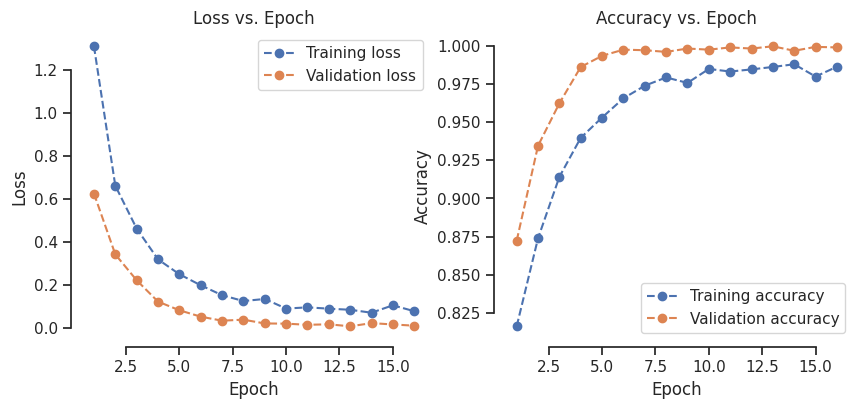

In [ ]:
plot_learning_curves(history)

In [ ]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Print the DataFrame
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,1.312630,0.816015,0.647783,0.578729,0.847561,0.625762,0.872247,0.797853,0.654919,0.932324
1,0.662127,0.873863,0.770413,0.705779,0.927163,0.341905,0.934655,0.896063,0.835536,0.983513
2,0.462415,0.914198,0.846702,0.801995,0.962190,0.221340,0.962555,0.940639,0.907489,0.993835
3,0.318824,0.939865,0.893345,0.862423,0.981421,0.121734,0.986417,0.976331,0.969163,0.998758
4,0.249421,0.953212,0.917194,0.893517,0.988854,0.081329,0.993759,0.992582,0.982379,0.998523
5,0.197946,0.965826,0.939647,0.922558,0.992416,0.051453,0.997797,0.997055,0.994126,0.999964
6,0.151684,0.974113,0.954762,0.941038,0.995740,0.032696,0.997430,0.995588,0.994126,0.999972
7,0.124330,0.979539,0.963018,0.954825,0.997288,0.037405,0.996329,0.992658,0.992658,0.999955
8,0.134017,0.975946,0.955096,0.948372,0.996198,0.019806,0.998532,0.997063,0.997063,0.999983
9,0.089219,0.985113,0.972026,0.968319,0.998592,0.018910,0.997797,0.995595,0.995595,0.999966


In [ ]:
image_path = '/content/drive/My Drive/archive/poisonous mushroom sporocarp/cv (18).jpg'
print("Predicted class is:", predict_image_class(vgg19_model, image_path))

In [ ]:
# Get the true labels
y_true = validation_generator.classes

# Predict the probability distribution of the data
predictions = vgg19_model.predict(validation_generator, verbose=1)

# Get the predicted class
y_pred = np.argmax(predictions, axis=1)

11/11 [==============================] - 5s 410ms/step


In [ ]:
vgg19_model.evaluate(validation_generator)

11/11 [==============================] - 5s 416ms/step - loss: 0.0094 - accuracy: 0.9993 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000


[0.009401295334100723,
 0.9992657899856567,
 0.9985315799713135,
 0.9985315799713135,
 0.9999963641166687]

### VGG16 Model (4)

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3), pooling = 'avg')

for layer in model.layers:
    layer.trainable = False

# Creating trainable layers
x = model.output
x = BatchNormalization()(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation = 'softmax')(x)

# Compute finetuned model
vgg16_model = Model(inputs = model.input, outputs = predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
vgg16_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = METRICS)

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = early_stop_patience)
cb_checkpointer = ModelCheckpoint(filepath = './vgg16.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
history = vgg16_model.fit(train_generator, epochs = 20, validation_data = validation_generator, callbacks = [cb_checkpointer, cb_early_stopper])

Epoch 1/20
54/54 [==============================] - 24s 421ms/step - loss: 1.3719 - accuracy: 0.8157 - precision: 0.6471 - recall: 0.5780 - auc: 0.8477 - val_loss: 0.5403 - val_accuracy: 0.8935 - val_precision: 0.8297 - val_recall: 0.7225 - val_auc: 0.9498
Epoch 2/20
54/54 [==============================] - 22s 411ms/step - loss: 0.6746 - accuracy: 0.8753 - precision: 0.7764 - recall: 0.7037 - auc: 0.9245 - val_loss: 0.3235 - val_accuracy: 0.9442 - val_precision: 0.9205 - val_recall: 0.8502 - val_auc: 0.9847
Epoch 3/20
54/54 [==============================] - 21s 392ms/step - loss: 0.4437 - accuracy: 0.9132 - precision: 0.8469 - recall: 0.7970 - auc: 0.9649 - val_loss: 0.1858 - val_accuracy: 0.9769 - val_precision: 0.9640 - val_recall: 0.9427 - val_auc: 0.9964
Epoch 4/20
54/54 [==============================] - 21s 393ms/step - loss: 0.3331 - accuracy: 0.9369 - precision: 0.8894 - recall: 0.8536 - auc: 0.9796 - val_loss: 0.1143 - val_accuracy: 0.9868 - val_precision: 0.9806 - val_recal

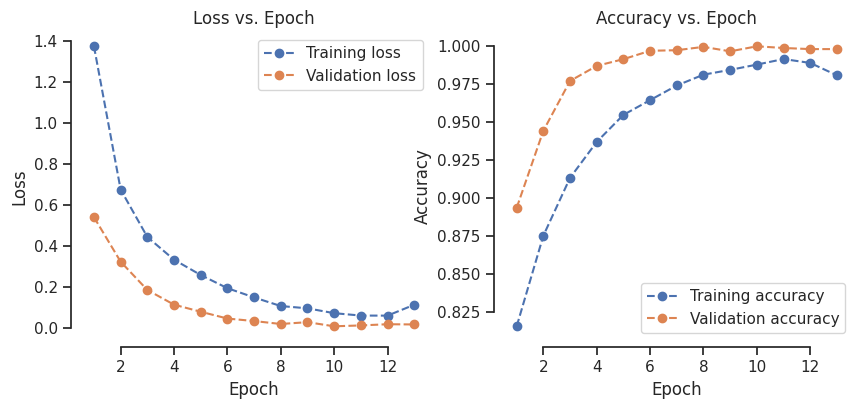

In [ ]:
plot_learning_curves(history)

In [ ]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Print the DataFrame
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,1.371857,0.815709,0.647139,0.577995,0.847694,0.540256,0.893539,0.829680,0.722467,0.949827
1,0.674561,0.875257,0.776375,0.703725,0.924499,0.323462,0.944200,0.920509,0.850220,0.984707
2,0.443736,0.913244,0.846945,0.797008,0.964880,0.185827,0.976872,0.963964,0.942731,0.996368
3,0.333141,0.936858,0.889364,0.853623,0.979627,0.114272,0.986784,0.980626,0.966226,0.998566
4,0.258678,0.954605,0.920688,0.895571,0.987535,0.079909,0.991189,0.988113,0.976505,0.999521
5,0.194535,0.964286,0.935859,0.920211,0.993153,0.046755,0.996696,0.994118,0.992658,0.999894
6,0.149576,0.973893,0.953910,0.941038,0.995680,0.034583,0.997063,0.994126,0.994126,0.999874
7,0.107587,0.981006,0.966805,0.956879,0.998187,0.020256,0.999266,0.998532,0.998532,0.999982
8,0.096538,0.984160,0.970528,0.965972,0.998368,0.029122,0.996329,0.992658,0.992658,0.999913
9,0.072894,0.987606,0.977876,0.972426,0.999166,0.008981,0.999633,1.000000,0.998532,1.000000


In [ ]:
# Get the true labels
y_true = validation_generator.classes

# Predict the probability distribution of the data
predictions = vgg16_model.predict(validation_generator, verbose=1)

# Get the predicted class
y_pred = np.argmax(predictions, axis=1)

11/11 [==============================] - 5s 380ms/step


In [ ]:
vgg16_model.evaluate(validation_generator)

11/11 [==============================] - 4s 368ms/step - loss: 0.0180 - accuracy: 0.9978 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000


[0.017991865053772926,
 0.9977973699569702,
 0.9955947399139404,
 0.9955947399139404,
 0.9999579787254333]